#### Load Libraries ####

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.backend import backend

from __future__ import print_function

import os
import re

import numpy as np
import PIL
from PIL import Image

from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential,Model
from keras.layers import Dense, Convolution2D, AveragePooling2D, MaxPooling2D, Flatten, Activation, UpSampling2D, Add, merge, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image as im
from keras.callbacks import Callback
from scipy.ndimage.filters import gaussian_filter

from keras.models import model_from_json

import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

%matplotlib inline

    

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import glob
from skimage import color
import scipy

def preprocess_single_image(img_name, datagen):
    image = plt.imread(img_name)
    
    if image.shape[0] > image.shape[1]:
        offset = int((image.shape[0] - image.shape[1]) / 2 + 1)
        image = image[offset:image.shape[1]+offset,:,:]
    elif image.shape[0] < image.shape[1]:
        offset = int((image.shape[1] - image.shape[0]) / 2 + 1)
        image = image[:,offset:image.shape[0]+offset,:]

    #resize
    image = scipy.misc.imresize(image, (224, 224), interp='bilinear')
    
    #random transform using data generators functions
    image = datagen.random_transform(image)
    
    return image

def preprocess_images(image_names, seed, datagen):
    np.random.seed(seed)
    images=[]
    for img_name in image_names:
        image = preprocess_single_image(img_name, datagen)
        images.append(image)
    return images



''' Convert color images to gray scales, color images to HUV format,
    return grayscale RGB image and UV channels of color image 
'''
def data_generator(image_name_path,batchsize):
    image_names = glob.glob(image_name_path)
    
    datagen_args = dict(rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        #shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        
                    )
    datagen = ImageDataGenerator(**datagen_args)
    seed = 1000
    
    while 1:
        batch = np.random.choice(image_names, batchsize,replace=False)
        rgbImages = preprocess_images(batch,seed,datagen)
        
        rgbImages = [ gaussian_filter(i,(.3,.3,0)) for i in rgbImages]
        
        grayScales = [ color.gray2rgb(color.rgb2gray(i)) for i in rgbImages]
        
        yuvColor = [ color.rgb2yuv(i) for i in rgbImages]
        #yuvGray = [ color.rgb2yuv(i) for i in grayScales]
        
        grayScale_arr = np.array(grayScales)
        rgb_arr = np.array(rgbImages)
        
        #grayScale_arr = preprocess_input(grayScale_arr)
        #yuvGray_arr = np.array(yuvGray)
        #yuvGray_arr[:,:,:,1:] = 0
        
        yuvColor_arr = np.array(yuvColor)[:,:,:,1:]
        
        
        
        yield grayScale_arr, yuvColor_arr
    
    

### Build Neural Net ###

##### Load Pretrained VGG16 Model #####

In [3]:
model = applications.VGG16(weights = "imagenet", include_top=True, input_shape = (224, 224, 3))

In [4]:
def buildModel_baseVGG16(vgg16_model):
    model = vgg16_model
    
    # add layers in front of vgg16
#     x = Convolution2D(filters=32, kernel_size=3, activation='relu', name='c_1')(x)
#     x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None, name='p_1')(x)
    
    
    layer = model.get_layer(name='block4_conv3')
    #layer
    x = BatchNormalization(name='n0')(layer.output)
    y = Convolution2D(filters=256, kernel_size=1, activation='tanh', name='c1')(x)

    y = UpSampling2D(name = 'up1', size=2)(y)
    x = BatchNormalization(name='n1')(model.get_layer(name='block3_conv3').output)
    z = merge((x,y), mode='concat', name='s1')
    #z = Concatenate((x,y))
    y = Convolution2D(filters=128, kernel_size=3, strides=1, activation='tanh', name='c2',padding='same')(z)

    y = UpSampling2D(name = 'up2', size=2)(y)
    x = BatchNormalization(name='n2')(model.get_layer(name='block2_conv2').output)
    z = merge((x,y), mode='concat', name='s2')
    y = Convolution2D(filters=64, kernel_size=3, strides=1, activation='tanh', name='c3',padding='same')(z)

    y = UpSampling2D(name = 'up3', size=2)(y)
    x = BatchNormalization(name='n3')(model.get_layer(name='block1_conv2').output)
    z = merge((x,y), mode='concat', name='s3')
    y = Convolution2D(filters=32, kernel_size=3, strides=1, activation='tanh', name='c4',padding='same')(z)
    y = Dropout(0.05)(y)

    x = BatchNormalization(name='n4')(model.get_layer(name=model.input_names[0]).output)
    z = merge((x,y), mode='concat', name='s4')
    y = Convolution2D(filters=8, kernel_size=3, strides=1, activation='tanh', name='c5',padding='same')(z)
    y = Dropout(0.05)(y)

    y = Convolution2D(filters=2, kernel_size=3, name='output', padding='same', activation='tanh')(y)

    model_final = Model(input = model.input, output = y)
    
    return model_final


In [5]:
model_final = buildModel_baseVGG16(model)
#model.get_layer(name=model.input_names[0]).output
model_final.summary()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ub

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792                                         
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928                                        
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0                                            
___________________________________________________________________________________________

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


##### Visualize Model #####

In [6]:
from IPython.display import SVG
import logging
from keras.utils.vis_utils import model_to_dot #, plot
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

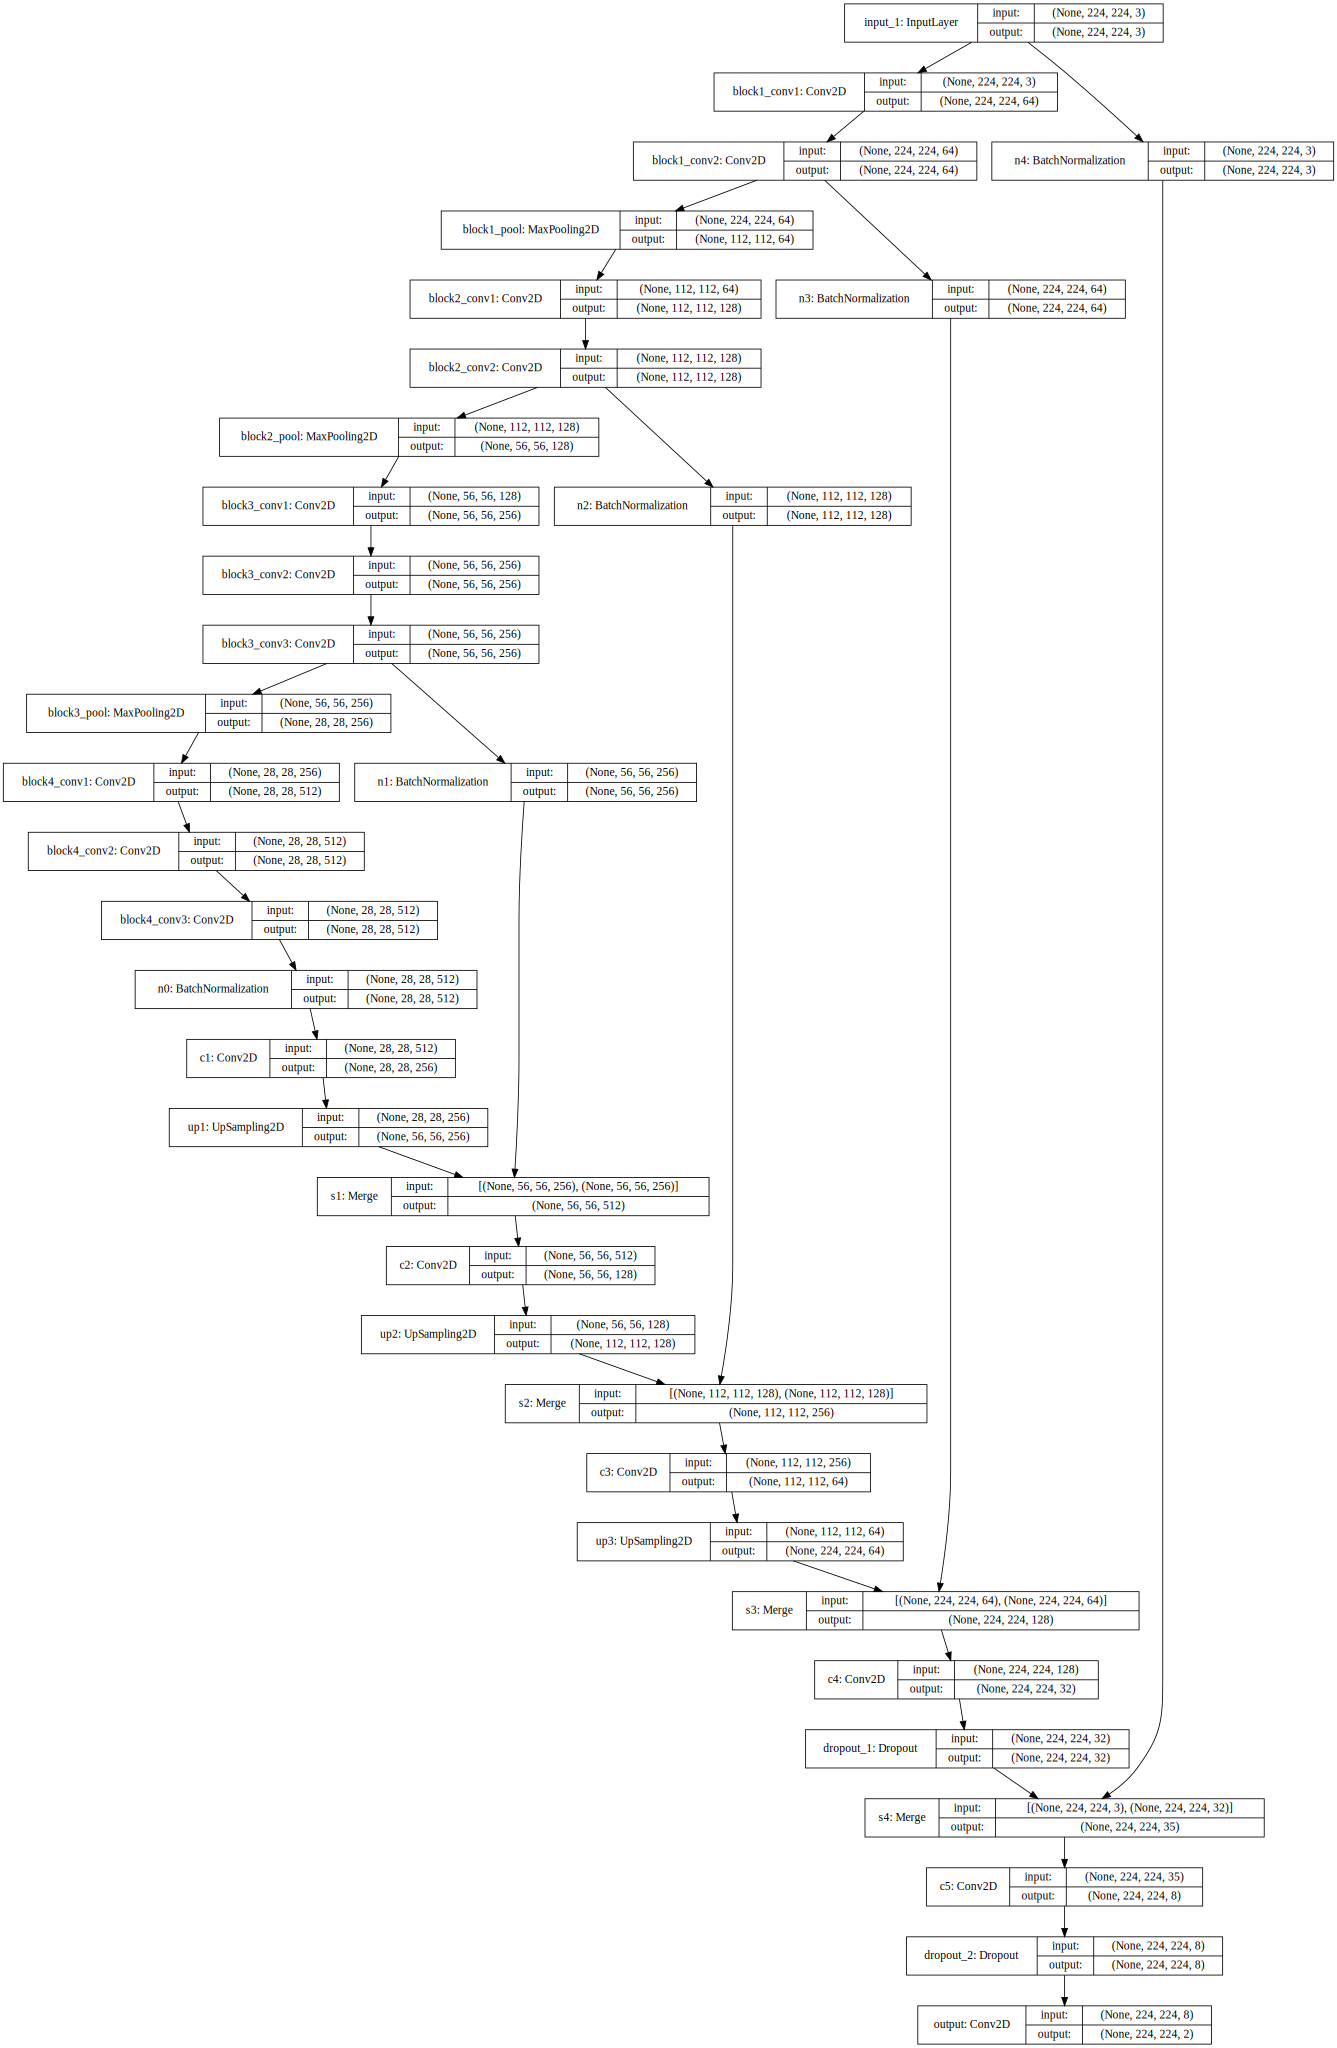

In [7]:
SVG(model_to_dot(model_final, show_shapes=True).create(prog='dot', format='svg'))

##### Compile Model #####

In [8]:
model_final.compile(loss="mean_squared_error", optimizer="adam")

#### Save Model ####

In [9]:
def saveModelAndWeights(model, filePrefix):
    model_json = model.to_json()
    with open(filePrefix + "_model.json", "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights(filePrefix + "_weights.h5")
    print("Saved model to disk")
    
def loadModel(filePrefix):
    with open(filePrefix + '_model.json', 'r') as json_file:
        loaded_model_json = json_file.read()

    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(filePrefix + "_weights.h5")
    
    print("Loaded model from disk")
    
    return(loaded_model)

In [10]:
saveModelAndWeights(model_final, filePrefix='tanh_blur_2_deepConv')

Saved model to disk


In [11]:
#model_final.load_weights('checkpoints_uv_tanh_lessblur_deepConv/backup/3pt_blur_weights.12-0.00375703.hdf5')

# for i in data_generator(TRAIN_IMAGE_PATH,BATCH_SIZE):
#     print(i)
#     break

#### Train Model ###

In [12]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        with open('losses.log', 'w') as lossLog:
            lossLog.write('')

    def on_batch_end(self, batch, logs={}):
        #self.losses.append(logs.get('loss'))
        with open('losses.log', 'a') as lossLog:
            lossLog.write(logs.get('loss').tostring())


In [13]:
# Define callback to save model checkpoints
if not os.path.exists('checkpoints_uv_tanh_lessblur_deepConv'):
    os.makedirs('checkpoints_uv_tanh_lessblur_deepConv')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints_uv_tanh_lessblur_deepConv', '3pt_blur_weights.{epoch:02d}-{val_loss:.8f}.hdf5'),
                                  monitor='loss', save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, epsilon=0.0001, cooldown=1)

# TensorBoard visualization
#tensorboard = TensorBoard(log_dir='logs/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)

csv_logger = CSVLogger('train_log_uv_tanh_blur_deepConv.csv', separator=',', append=True)
lossHistory = LossHistory()
# Train the model
# model = get_unet(0.001)
# model_fin.fit(X_train, Y_train, batch_size=32, epochs=NUM_EPOCHS, verbose=1, shuffle=True,
#          callbacks=[model_checkpoint, reduce_lr, tensorboard], validation_data=(X_val, Y_val))

In [35]:
#TRAIN_IMAGE_PATH = '../flickr30k-images/*.jpg'
#VALIDATION_IMAGE_NAME_PATH = '../flickr30k-images_validation/*.jpg'

TRAIN_IMAGE_PATH = 'data/images/*.JPEG'
VALIDATION_IMAGE_NAME_PATH = 'data/validationImages/*.JPEG'



BATCH_SIZE = 20
VALIDATION_BATCH_SIZE = int(BATCH_SIZE * .1)
NUM_EPOCHS = 2000
TRAIN_STEPS_PER_EPOCH = len(glob.glob(TRAIN_IMAGE_PATH))// BATCH_SIZE
VALIDATION_STEPS_PER_EPOCH = len(glob.glob(VALIDATION_IMAGE_NAME_PATH))// VALIDATION_BATCH_SIZE

train_Gen = data_generator(TRAIN_IMAGE_PATH,BATCH_SIZE)
validation_dGen = data_generator(VALIDATION_IMAGE_NAME_PATH,VALIDATION_BATCH_SIZE)



In [30]:
for i in train_Gen:
    break

(20, 224, 224, 2)

In [ ]:
history = model_final.fit_generator(
generator=train_Gen,
steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
epochs = NUM_EPOCHS,
validation_data = validation_dGen,
#nb_val_samples = 20,
verbose = 1,
validation_steps = VALIDATION_STEPS_PER_EPOCH,
callbacks = [model_checkpoint, reduce_lr, csv_logger],
workers=1)

Epoch 1/2000
2250/2250 [==============================] - 5190s - loss: 2.0748e-04 - val_loss: 0.0024
Epoch 9/2000
2250/2250 [==============================] - 5188s - loss: 1.7714e-04 - val_loss: 0.0022
Epoch 11/2000
2250/2250 [==============================] - 5181s - loss: 1.5816e-04 - val_loss: 0.0024
Epoch 12/2000
 755/2250 [=========>....................] - ETA: 3304s - loss: 1.7263e-04

In [ ]:
#dat = plt.imread('../flickr30k-images/1000092795.jpg')

colorImg=preprocess_single_image('data/validationImages/frame118000.jpg', ImageDataGenerator())
#plt.imshow(dat)

grayImg = color.rgb2gray(colorImg)
grayImg3Ch = np.zeros(colorImg.shape)
grayImg3Ch[:,:,0] = grayImg
grayImg3Ch[:,:,1] = grayImg
grayImg3Ch[:,:,2] = grayImg

yuvColorImg = color.rgb2yuv(colorImg)
yuvGrayImg = np.zeros(colorImg.shape)
yuvGrayImg[:,:,0] = yuvColorImg[:,:,0]


In [ ]:
uvResult = model_final.predict(np.expand_dims(grayImg3Ch,0))
print(np.min(uvResult),np.max(uvResult))

In [ ]:
plt.hist(yuvColorImg[:,:,1])
plt.xlim(-.5,.5)

In [ ]:
plt.hist(uvResult[0,:,:,1]/10)
plt.xlim(-.5,0.5)

In [ ]:
plt.imshow(colorImg)

In [ ]:
pred_YUVImg = np.zeros(colorImg.shape)
pred_YUVImg[:,:,0] = yuvColorImg[:,:,0]
pred_YUVImg[:,:,1] = uvResult[0,:,:,0]/10
pred_YUVImg[:,:,2] = uvResult[0,:,:,1]/10

pred_YUVImg[pred_YUVImg[:,:,1]>0.5,1] = 0.5
pred_YUVImg[pred_YUVImg[:,:,1]<(-0.5),1] = -0.5

pred_YUVImg[pred_YUVImg[:,:,2]>0.5,2] = 0.49999
pred_YUVImg[pred_YUVImg[:,:,2]<(-0.5),2] = -0.49999

plt.imshow(color.yuv2rgb(pred_YUVImg))

In [ ]:
# from twilio.rest import Client

# # Find these values at https://twilio.com/user/account
# account_sid = "ACXXXXXXXXXXXXXXXXX"
# auth_token = "YYYYYYYYYYYYYYYYYY"
# client = Client(account_sid, auth_token)

# message = client.api.account.messages.create(to="+12316851234",
#                                              from_="+15555555555",
#                                              body="Hello there!")

In [ ]:
j = plt.imread('data/validationImages/frame118000.jpg')
k = gaussian_filter(colorImg,(1,1,0))

plt.imshow(k)

In [ ]:
np.min(colorImg)